The purpose of this project is to reproduce the results from the paper by [Asuncion et al., Philippine Journal of Science, 2019](https://github.com/pgniewko/conotoxins/tree/master/papers/ASA.PJS.2019.pdf) and have some fun playing with the Python code. The data used in this study was downloaded from the [ConoServer](http://www.conoserver.org/?page=download) (access data: 11/18/19). Instead of using [protr](https://cran.r-project.org/web/packages/protr/vignettes/protr.html) package for peptides featurizaion (as was done in the original paper), I used a Python implementation of [pydpi](https://pypi.org/project/pydpi/#files). `pydpi` was originally implemented in Python 2, so I have [made it work](https://github.com/pgniewko/conotoxins/tree/master/external/py3dpi) with Python 3. Other tools could also be used e.g. [iFeature](https://github.com/Superzchen/iFeature/) by [Chen et al., Bioinformatics 2018](https://github.com/pgniewko/conotoxins/tree/master/papers/iFeature.2018.pdf).

Note: one thing to keep in mind is that the amount of labeled data available is relatively small, c.a. 100-200. Thus, DL methods are as good many classical ML techniques; and possibly worst as they have a great tendency to overfit on small datasets).  

In [8]:
import sys
import logging
import xml.etree.ElementTree as ET


from toxin import Toxin
from experiment import Experiment


import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from scipy import stats
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

logging.basicConfig(filename='conotoxins.log', level=logging.DEBUG)

First we read and parse the XML file. Next, we create "toxin" objects for all available data.

In [2]:
db_file = "../data/conoserver/conoserver_protein.xml"
tree = ET.parse(db_file)
root = tree.getroot()

toxins = []
for entry in root.iter('entry'):
    pid = entry.find('id').text if entry.find('id') is not None else None
    seq = entry.find('sequence').text if entry.find('sequence') is not None else "None"
    name = entry.find('name').text if entry.find('name') is not None else "None"
    toxin_class =  entry.find('class').text if entry.find('class') is not None else "None"
    organism = entry.find('organismLatin').text if entry.find('organismLatin') is not None else "None"
    geneSuperfamily = entry.find('geneSuperfamily').text if entry.find('geneSuperfamily') is not None else "None"
    cysteineFramewrok = entry.find('cysteineFramewrok').text if entry.find('cysteineFramewrok') is not None else "None"
    pharmacologicalFamily = entry.find('pharmacologicalFamily').text if entry.find('pharmacologicalFamily') is not None else "None"
    isoelecticPoint = entry.find('isoelecticPoint').text if entry.find('isoelecticPoint') is not None else "None"
    
    toxin = Toxin(pid,
                  seq,
                  name,
                  toxin_class,
                  organism,
                  geneSuperfamily,
                  cysteineFramewrok,
                  pharmacologicalFamily, 
                  isoelecticPoint)
    
    mods = entry.find('sequenceModifications')
    if mods is not None:
        for mod in mods.iter('modification'):
            toxin.add_modification( mod.attrib )
    
    toxin._clean_seq()
    toxins.append(toxin)

I built the dataset two ways. The first one was an automated parsing of the XML file, given the specs provied in the paper. The second approach was to take the protein ids, sequences and molecular targets from the [paper](Asuncion et al., Philippine Journal of Science, 2019). I noticed that the data in the paper differes (moslty for $\alpha$-toxins) from the one extracted by my cde. It seems that the data used in the paper was manually curated; even if the records in the ConoServer was incomplete authors decided to assign certein pharmacological family to the toxin. Some toxins that don't have specified target, were included wheres some peptides that have well defined target were exluded from the dataset. Moreover, 4 peptides that were inlcuded in the original study, is missing in the data downlaoded from the ConoServer. It due to the fact, that for these 4 cases, a precursor is ginve not an actuall mature peptide. To be able to work with these cases, the following changes weremade to their sequneces:

|Protein ID| Position  | Mature amino-acid | Original amino-acid|        
|------|----|---|----|   
|P06822| 2  | X | W  |    
|P06822| 6  | X | P  |    
|P06822| 24 | X | C  |
|P07401| 2  | X | E  |    
|P07401| 3  | X | E  |    
|P07401| 7  | X | E  |
|P07401| 10 | X | "" |
|P07646| 4  | X | P  |
|P07646| 10 | X | P  |
|P07647| 4  | X | P  |  
|P07647| 10 | X | P  |

For the other aminoacids, the sequence was changed to the original sequence using information contained in `sequenceModifications` field.

In the next step, I prepared an experiment with a sequnce featurization. In this work I used the same features as in the original [work](https://github.com/pgniewko/conotoxins/blob/master/papers/ASA.PJS.2019.pdf) except tri-peptide composition descriptors as these are very sparse for short peptides, and were intorducing excesive amount of noise.

In [3]:
experiment = Experiment(toxins, min_val=8)
if False:
    experiment.prepare_experiment()
else:
    experiment.experiment_from_file('../data/ASA.PJS.2019.txt')

data, labels, labels_map = experiment.get_data()   

When the sequences are featurized, I turned the features into Z-scores. However, we have a sample of only 153 labeled sequences, some of the peptides are failry small and many features are absent in all the studied cases. Thus, to avoid numerical issues, I removed all the single-value columns. Once they were removed, I perfrmed Z-scores transforamtion, and calculated principal compontens.  
In the original work, 137 features were used whereas 153 sequences were studied. The fact that the number of features is comparable to the number of samples opens a great possibility for the model to overfit and I treat the reported results with caution. The number of PCs, equal to 137, was chosen in the origianl work as the number of PCs that explain 99% variability in the data. In the work below, I plotted the number of explained data variability up to 100 PCs, but to buid a model I used only 10 most important PCs.

In [4]:
data_cleaded = []
for i in range(data.shape[1]):
    std= np.std(data[:,i])
    if std != 0:
        data_cleaded.append(data[:,i])
data_cleaded = np.array(data_cleaded)
data_cleaded = data_cleaded.T

zscores = stats.zscore(data_cleaded, axis=0, ddof=1)
pca = PCA(n_components=100)
zscores_pca = pca.fit_transform(zscores)

The plot on the left gives the amount of data variation explained by a certain number of Principal Components. Inthe middle I give the labeled data in 2D space spanned by two most important PCs. Finally, using 10 most important PCs, I embedded the data into the 2D-space with t-SNE algorithm. 

Text(0, 0.5, 'X 2')

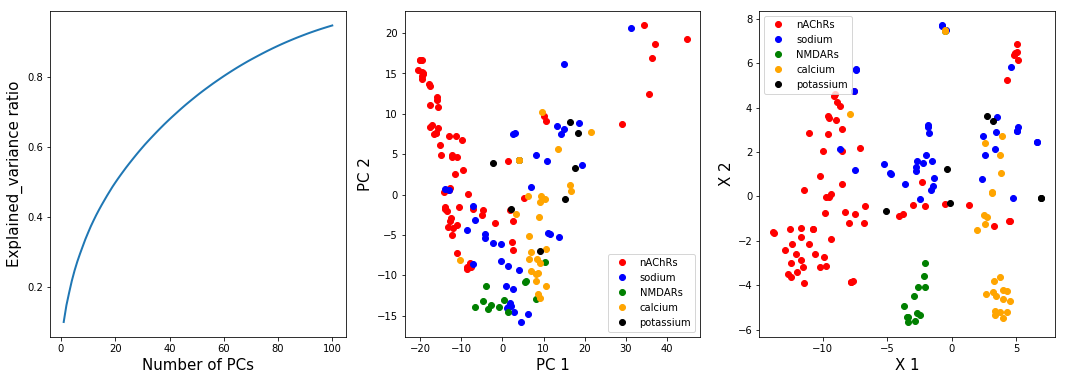

<Figure size 504x504 with 0 Axes>

In [5]:
fig, axis = plt.subplots(1, 3, figsize=(18,6))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]


y = np.cumsum(pca.explained_variance_ratio_)
x = [i+1 for i in range(len(y))]

fig = plt.figure(figsize=(7, 7))
ax1.plot(x, y, lw=2)
ax1.set_xlabel('Number of PCs', fontsize=15)
ax1.set_ylabel('Explained_variance ratio', fontsize=15)


# Each class correspond to the molecular target
color_map = {0:'red', 1:'blue', 2:'green', 3:'orange', 4:'black'}

for label, color in color_map.items():
    x = [zscores_pca[i, 0] for i in range(len(labels)) if labels[i] == label]
    y = [zscores_pca[i, 1] for i in range(len(labels)) if labels[i] == label]
    ax2.plot(x, y, 'o', c=color, label=labels_map[label])
ax2.legend()
ax2.set_xlabel("PC 1", fontsize=15)
ax2.set_ylabel("PC 2", fontsize=15)

# Embed first 10 PCs. 
X_embedded = TSNE(n_components=2).fit_transform(zscores_pca[:,0:10])

for label, color in color_map.items():
    x = [X_embedded[i,0] for i in range(len(labels)) if labels[i] == label]
    y = [X_embedded[i,1] for i in range(len(labels)) if labels[i] == label]
    ax3.plot(x, y, 'o', c=color, label=labels_map[label])
ax3.legend()
ax3.set_xlabel("X 1", fontsize=15)
ax3.set_ylabel("X 2", fontsize=15)

# Embedding all the data

I wanted to check how the labeled data is represnted in the context of all available data. To that end I prepared an expriment with annotated and unannotated datapoints.

In [5]:
experiment_all_data = Experiment(toxins, min_val=1)
experiment_all_data.prepare_experiment(strict=False)
if False:
    data_all, labels_all, labels_map_all = experiment_all_data.get_data()
    experiment_all_data.dump_data('../data/partial/conotoxins.pckl', data_all, labels_all, labels_map_all)
else:
    data_all, labels_all, labels_map_all = experiment_all_data.load_data('../data/partial/conotoxins.pckl')

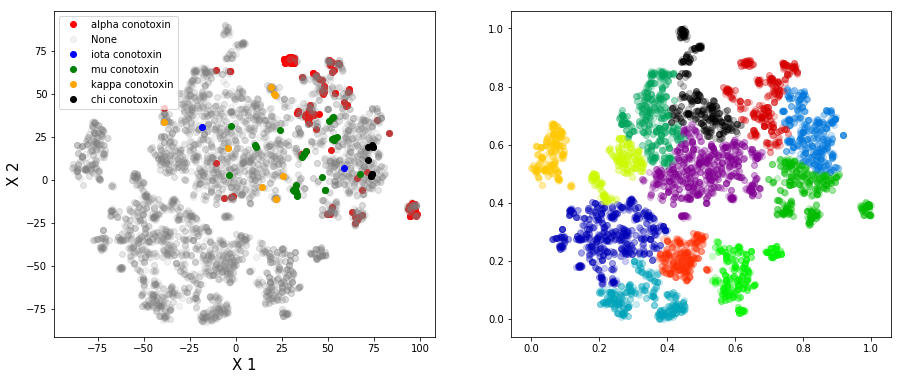

In [9]:
fig, axis = plt.subplots(1, 2, figsize=(15,6))

ax1 = axis[0]
ax2 = axis[1]


color_map_all = {0:'red', 1:'grey', 2:'blue', 3:'green', 4:'orange', 5:'black'}

data_cleaded_all = []
for i in range(data_all.shape[1]):
    std= np.std(data_all[:,i])
    if std != 0:
        data_cleaded_all.append(data_all[:,i])
data_cleaded_all = np.array(data_cleaded_all)
data_cleaded_all = data_cleaded_all.T

zscores_all = stats.zscore(data_cleaded_all, axis=0, ddof=1)
pca_all = PCA(n_components=100)
zscores_pca_all = pca_all.fit_transform(zscores_all)

# Embed first 10 PCs. 
X_embedded = TSNE(n_components=2).fit_transform(zscores_pca_all[:, 0:10])

for label, color in color_map_all.items():
    alpha = 1.0
    x = [X_embedded[i,0] for i in range(len(labels_all)) if labels_all[i] == label]
    y = [X_embedded[i,1] for i in range(len(labels_all)) if labels_all[i] == label]
    if len(x) > 0:
        if labels_map_all[label] == 'None':
            alpha = 0.1
        ax1.plot(x, y, 'o', c=color, label=labels_map_all[label], alpha=alpha)
ax1.legend()
ax1.set_xlabel("X 1", fontsize=15)
ax1.set_ylabel("X 2", fontsize=15)

## CLUSTERING
X_red = X_embedded[:,0:2]
clustering = AgglomerativeClustering(n_clusters=12).fit(X_red)

labels = clustering.labels_
x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
X_red = (X_red - x_min) / (x_max - x_min)

for i in range(X_red.shape[0]):
    ax2.scatter(X_red[i, 0], X_red[i, 1],
                color=plt.cm.nipy_spectral(labels[i] / 12.), alpha=0.2)

In the plot on the right hand side I clustered 2D embedding with the number of clusters equal to 12 - the number of known pharmacological families.

# Statistics 

The statistics are calculated for the data from [Asuncion et al.](https://github.com/pgniewko/conotoxins/tree/master/papers/ASA.PJS.2019.pdf) paper.         

In the following [paper](https://github.com/pgniewko/conotoxins/blob/master/papers/DJS.MD.2017.pdf), the authors suggested some methods for features selection. However, the methods proposed are not the proper way of doing it. Namely, the starting number of features is fairly large - the order of couple thousands. Then authors suggest to search for a small number of results that give the best values of the accuracy metrics. This approach is known to be incorrect, as the combination of features can happen to delived an accurate prediction just by [chance](https://pubs.acs.org/doi/abs/10.1021/ci700157b). This can explain surprisingly good preformances, c.a. 95%, reported by some [authors](https://www.ncbi.nlm.nih.gov/pubmed/27631006).

### Global Metrics

In [7]:
X = zscores_pca[:,0:50]
y = labels
y_true = []
y_pred = []
kf = KFold(n_splits=50, random_state=42, shuffle=True )
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg')).fit(X_train, y_train)
    y_pred += list(clf.predict(X_test))
    y_true += list(y_test)

In [51]:
print("Accuracy = ", accuracy_score(y_true, y_pred))
print("F1-score = ", f1_score(y_true, y_pred, average='weighted'))
print("Precision = ", precision_score(y_true, y_pred,average='weighted'))
print("Recall = ", recall_score(y_true, y_pred, average='weighted'))
print("Cohen kappa =", cohen_kappa_score(y_true, y_pred))

Accuracy =  0.869281045751634
F1-score =  0.8694395260891424
Precision =  0.8732959850606908
Recall =  0.869281045751634
Cohen kappa = 0.811367279003822


### Per class statistics

In [52]:
columns = [labels_map[label] for label in color_map.keys()]
columns = [labels_map[label] for label in color_map.keys()]
metrics = ['Precision', 'Recalls', 'F-score', 'Support']
df = pd.DataFrame(mat, columns=columns, index = metrics)
df

,nAChRs,sodium,NMDARs,calcium,potassium
Precision,0.942857,0.750000,1.000000,0.777778,1.000000
Recalls,0.970588,0.789474,0.846154,0.777778,0.714286
F-score,0.956522,0.769231,0.916667,0.777778,0.833333
Support,68.000000,38.000000,13.000000,27.000000,7.000000


### Confusion matrix

In [50]:
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=columns)
df_cm

,nAChRs,sodium,NMDARs,calcium,potassium
nAChRs,66,2,0,0,0
sodium,3,30,0,5,0
NMDARs,0,1,11,1,0
calcium,0,6,0,21,0
potassium,1,1,0,0,5
